In [ ]:
import os
os.chdir('../')

In [1]:
import argparse

import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from lateral_connections import LateralModel, VggModel
from lateral_connections import VggWithLCL
from lateral_connections import MNISTCDataset
from lateral_connections.loaders import get_loaders, load_mnistc
from lateral_connections.character_models import SmallVggWithLCL, VGGReconstructionLCL
from lateral_connections.torch_utils import *
from lateral_connections.model_factory import *

import datetime

vggonly_model_path = 'models/vgg_with_lcl/VGG19_2022-04-04_183636__it16250_e3.pt'
vgg19r_lcl5_model_path = 'models/vgg_reconstructed_lcl/2022-04-24_004459_LCL5_d2__it23750_e4.pt'

vgg19r_lcl__fc_only__model_path = 'models/vgg_reconstructed_lcl/2022-05-04_091715_LCL5_d2__it23750_e4.pt'
vgg19r_lcl__random_multiplex_selection__model_path = 'models/vgg_reconstructed_lcl/2022-05-02_131013_LCL5_d2__it17500_e3.pt'
vgg19r_lcl__random_k_change__model_path = 'models/vgg_reconstructed_lcl/2022-05-02_063619_LCL5_d2__it8750_e1.pt'

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
def plot_lcl_kernel(model, num_plots=5, plot_scale=2):
    fig, axs = plt.subplots(num_plots, num_plots, figsize=(num_plots*plot_scale, num_plots*plot_scale))

    for x in range(num_plots):
        for y in range(num_plots):
            axs[x,y].imshow(model.features.lcl.K[x, y, ...].cpu().detach().numpy())

    plt.tight_layout()
    plt.show()

#vgg19r = load_model_by_key('vgg19r_lcl', vgg19r_lcl5_model_path)
#plot_lcl_kernel(vgg19r)
#vgg19r

In [4]:
dataset_identity = load_mnistc(dirname='identity')
dataset_line = load_mnistc(dirname='line')
dataset_gaussian_noise = load_mnistc(dirname='gaussian_noise')

### Extract LCL Output

In [5]:
def run_through_vgg(model, batch):
    batch = batch.to(model.device)
    return model.features.vgg19_unit(batch)
    
def run_through_lcl(model, batch):
    batch = batch.to(model.device)
    return model.features.lcl(batch)
    
def extract_output(model, dataset, batch_size=10):
    model.eval()
    iter_ds = iter(torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1))

    all_labels = np.zeros((len(dataset),))
    all_vgg = np.zeros((len(dataset), 512, 7, 7))
    all_lcl = np.zeros((len(dataset), 512, 7, 7))

    for i, (imgs, lbls) in tqdm(enumerate(iter_ds, 0), total=len(iter_ds)):
        y1 = run_through_vgg(model, imgs)
        y2 = run_through_lcl(model, y1)

        all_labels[batch_size*i:batch_size*i+batch_size] = lbls.cpu().detach().numpy()
        all_vgg[batch_size*i:batch_size*i+batch_size, ...] = y1.cpu().detach().numpy()
        all_lcl[batch_size*i:batch_size*i+batch_size, ...] = y2.cpu().detach().numpy()

    return all_vgg, all_lcl, all_labels

In [6]:
"""
all_vgg, all_lcl, all_labels = extract_output(vgg19r, dataset_gaussian_noise)
np.save(vgg19r_lcl5_model_path[:-3] + '__gaussian_noise__vgg_activations.npy', all_vgg)
np.save(vgg19r_lcl5_model_path[:-3] + '__gaussian_noise__lcl_activations.npy', all_lcl)
np.save(vgg19r_lcl5_model_path[:-3] + '__gaussian_noise__labels.npy', all_labels)

all_vgg, all_lcl, all_labels = extract_output(vgg19r, dataset_identity)
np.save(vgg19r_lcl5_model_path[:-3] + '__identity__vgg_activations.npy', all_vgg)
np.save(vgg19r_lcl5_model_path[:-3] + '__identity__lcl_activations.npy', all_lcl)
np.save(vgg19r_lcl5_model_path[:-3] + '__identity__labels.npy', all_labels)
"""

"\nall_vgg, all_lcl, all_labels = extract_output(vgg19r, dataset_gaussian_noise)\nnp.save(vgg19r_lcl5_model_path[:-3] + '__gaussian_noise__vgg_activations.npy', all_vgg)\nnp.save(vgg19r_lcl5_model_path[:-3] + '__gaussian_noise__lcl_activations.npy', all_lcl)\nnp.save(vgg19r_lcl5_model_path[:-3] + '__gaussian_noise__labels.npy', all_labels)\n\nall_vgg, all_lcl, all_labels = extract_output(vgg19r, dataset_identity)\nnp.save(vgg19r_lcl5_model_path[:-3] + '__identity__vgg_activations.npy', all_vgg)\nnp.save(vgg19r_lcl5_model_path[:-3] + '__identity__lcl_activations.npy', all_lcl)\nnp.save(vgg19r_lcl5_model_path[:-3] + '__identity__labels.npy', all_labels)\n"

In [164]:
data = {
    'identity': {
        'vgg': np.load(vgg19r_lcl5_model_path[:-3] + '__identity__vgg_activations.npy'),
        'lcl': np.load(vgg19r_lcl5_model_path[:-3] + '__identity__lcl_activations.npy'),
        'labels': np.load(vgg19r_lcl5_model_path[:-3] + '__identity__labels.npy'),
        'vgg_pred': pd.read_csv('mnist_c__identity__vggonly__predictions.csv')['prediction'].to_numpy(),
        'lcl_pred': pd.read_csv('mnist_c__identity__vgg19r_lcl5__predictions.csv')['prediction'].to_numpy()
    },
    'gaussian_noise': {
        'vgg': np.load(vgg19r_lcl5_model_path[:-3] + '__gaussian_noise__vgg_activations.npy'),
        'lcl': np.load(vgg19r_lcl5_model_path[:-3] + '__gaussian_noise__lcl_activations.npy'),
        'labels': np.load(vgg19r_lcl5_model_path[:-3] + '__gaussian_noise__labels.npy'),
        'vgg_pred': pd.read_csv('mnist_c__gaussian_noise__vggonly__predictions.csv')['prediction'].to_numpy(),
        'lcl_pred': pd.read_csv('mnist_c__gaussian_noise__vgg19r_lcl5__predictions.csv')['prediction'].to_numpy()
    },
    'line': {
        'labels': pd.read_csv('mnist_c__line__vggonly__predictions.csv')['label'].to_numpy(),
        'vgg_pred': pd.read_csv('mnist_c__line__vggonly__predictions.csv')['prediction'].to_numpy(),
        'lcl_pred': pd.read_csv('mnist_c__line__vgg19r_lcl5__predictions.csv')['prediction'].to_numpy()
    }
}



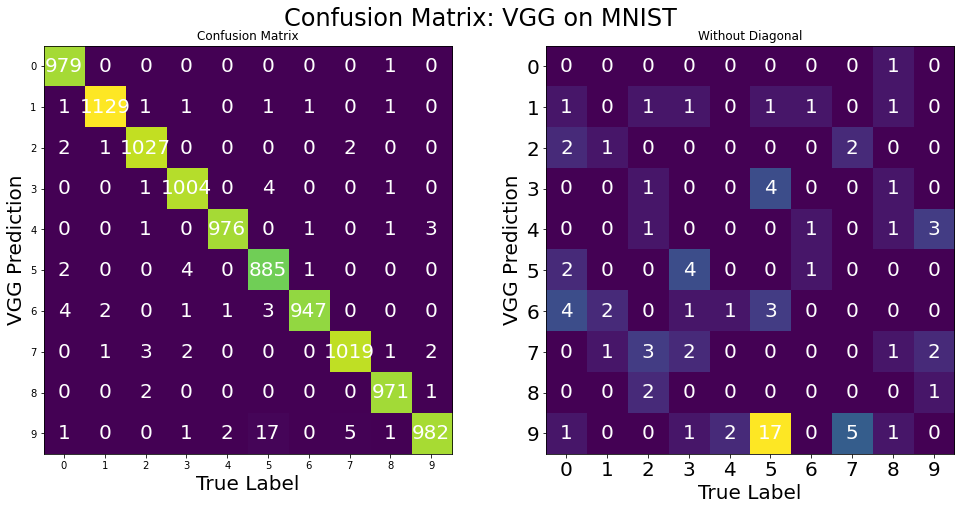

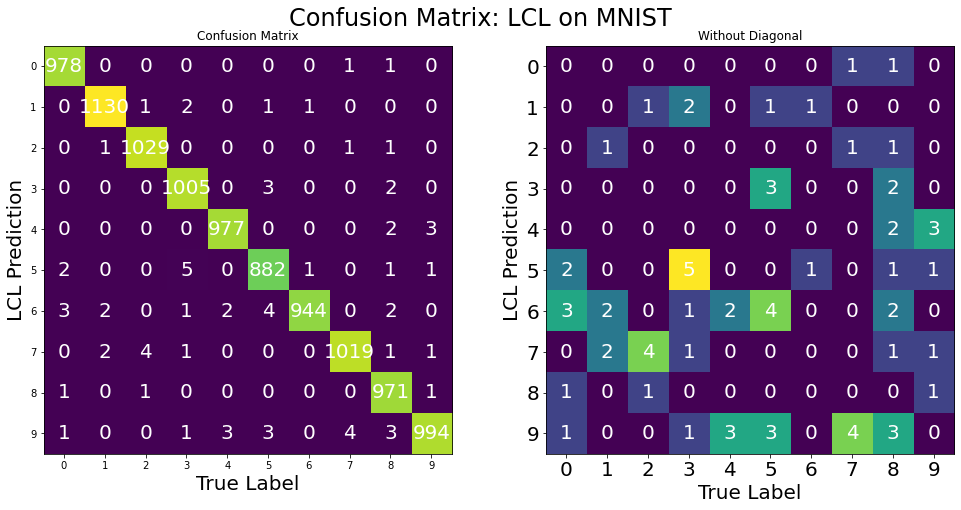

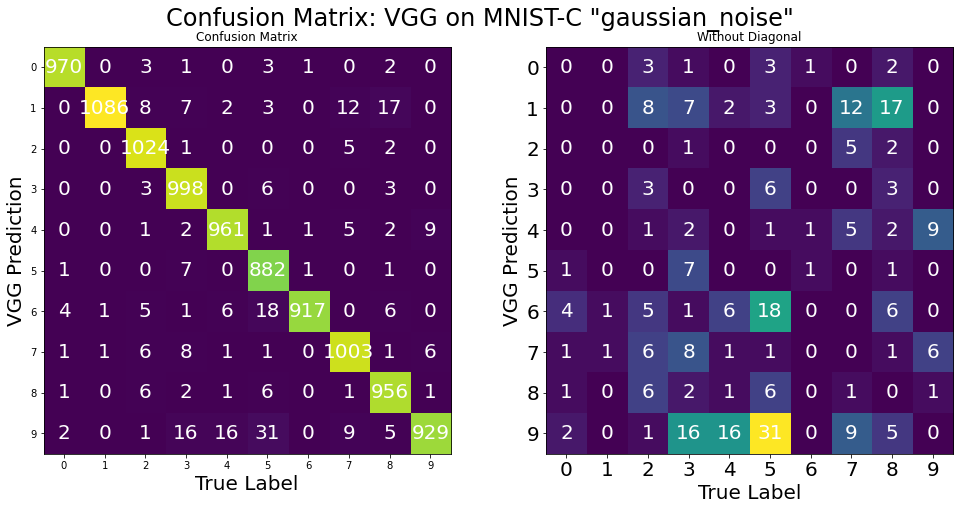

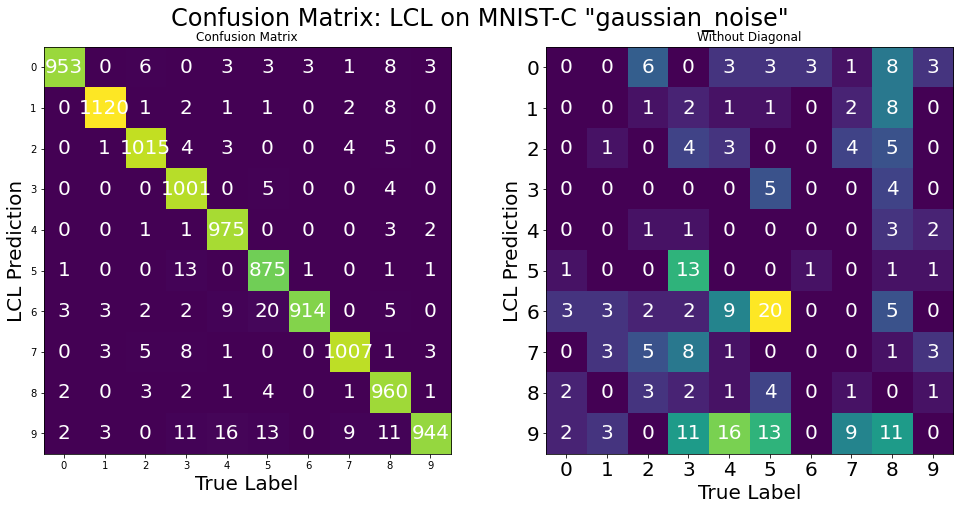

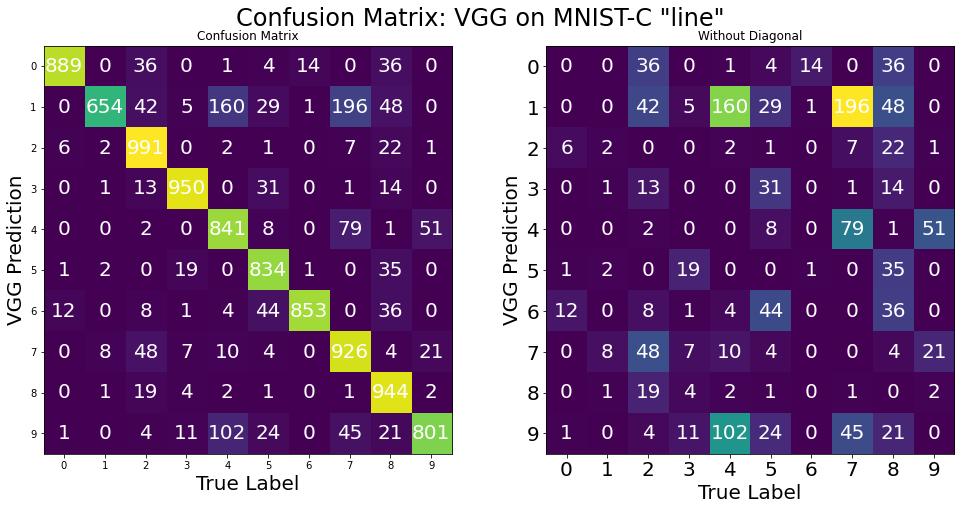

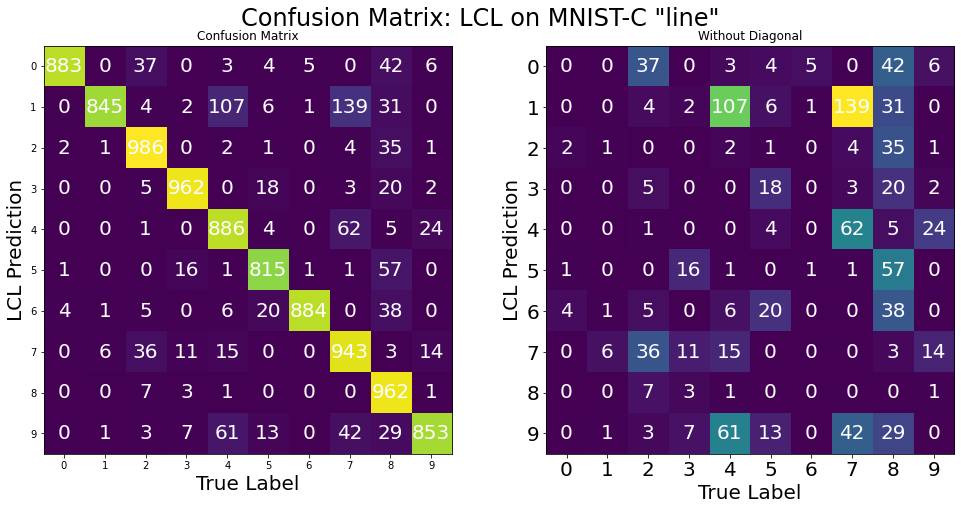

In [165]:
from sklearn.metrics import confusion_matrix

def show_cm_plot(cm, ylabel_text='VGG Prediction', suptitle_text='Confusion Matrix: VGG on MNIST-C "gaussian_noise"'):
    fig, axs = plt.subplots(1, 2, figsize=(14,7))
    
    ax = axs[0]
    ax.imshow(cm)

    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(10))
    ax.set_xlabel('True Label', fontsize=20)
    ax.set_ylabel(ylabel_text, fontsize=20)
    for x in range(10):
        for y in range(10):
            ax.text(y, x, cm[x,y], ha='center', va='center', color='w', size=20)

    ax.set_title('Confusion Matrix')
    ax = axs[1]
    cm[np.arange(10), np.arange(10)] = 0
    ax.imshow(cm)

    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(10))
    ax.set_xlabel('True Label', fontsize=20)
    ax.set_ylabel(ylabel_text, fontsize=20)
    for x in range(10):
        for y in range(10):
            ax.text(y, x, cm[x,y], ha='center', va='center', color='w', size=20)
            
    ax.set_title('Without Diagonal')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.suptitle(suptitle_text, size=24)
    plt.tight_layout()
    plt.show()

    
cm = confusion_matrix(data['identity']['labels'], data['identity']['vgg_pred'])
show_cm_plot(cm, 'VGG Prediction', 'Confusion Matrix: VGG on MNIST')

cm = confusion_matrix(data['identity']['labels'], data['identity']['lcl_pred'])
show_cm_plot(cm, 'LCL Prediction', 'Confusion Matrix: LCL on MNIST')

cm = confusion_matrix(data['gaussian_noise']['labels'], data['gaussian_noise']['vgg_pred'])
show_cm_plot(cm, 'VGG Prediction', 'Confusion Matrix: VGG on MNIST-C "gaussian_noise"')

cm = confusion_matrix(data['gaussian_noise']['labels'], data['gaussian_noise']['lcl_pred'])
show_cm_plot(cm, 'LCL Prediction', 'Confusion Matrix: LCL on MNIST-C "gaussian_noise"')

cm = confusion_matrix(data['line']['labels'], data['line']['vgg_pred'])
show_cm_plot(cm, 'VGG Prediction', 'Confusion Matrix: VGG on MNIST-C "line"')

cm = confusion_matrix(data['line']['labels'], data['line']['lcl_pred'])
show_cm_plot(cm, 'LCL Prediction', 'Confusion Matrix: LCL on MNIST-C "line"')

In [8]:
full = np.concatenate((data['identity']['vgg'], data['identity']['lcl'], data['gaussian_noise']['vgg'], data['gaussian_noise']['lcl']))
full = full.reshape(full.shape[0], full.shape[1]*full.shape[2]*full.shape[3])
full.shape

(40000, 25088)

### PCA

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(full)

# array([0.10350789, 0.0665342 ])
print("Explained Variance: ", pca.explained_variance_ratio_)

PCA(n_components=2)

-94.73945855105657 144.00778560626526 -103.15175166277 127.7783009458996


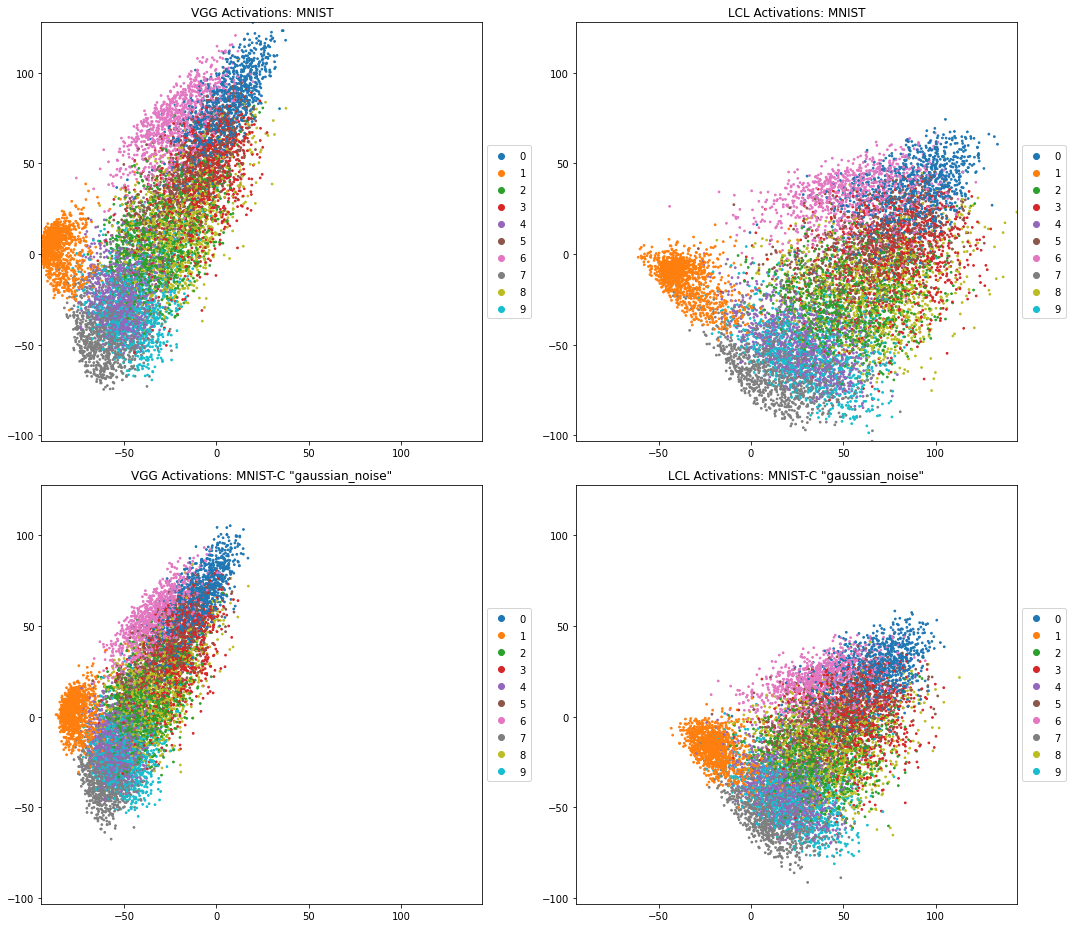

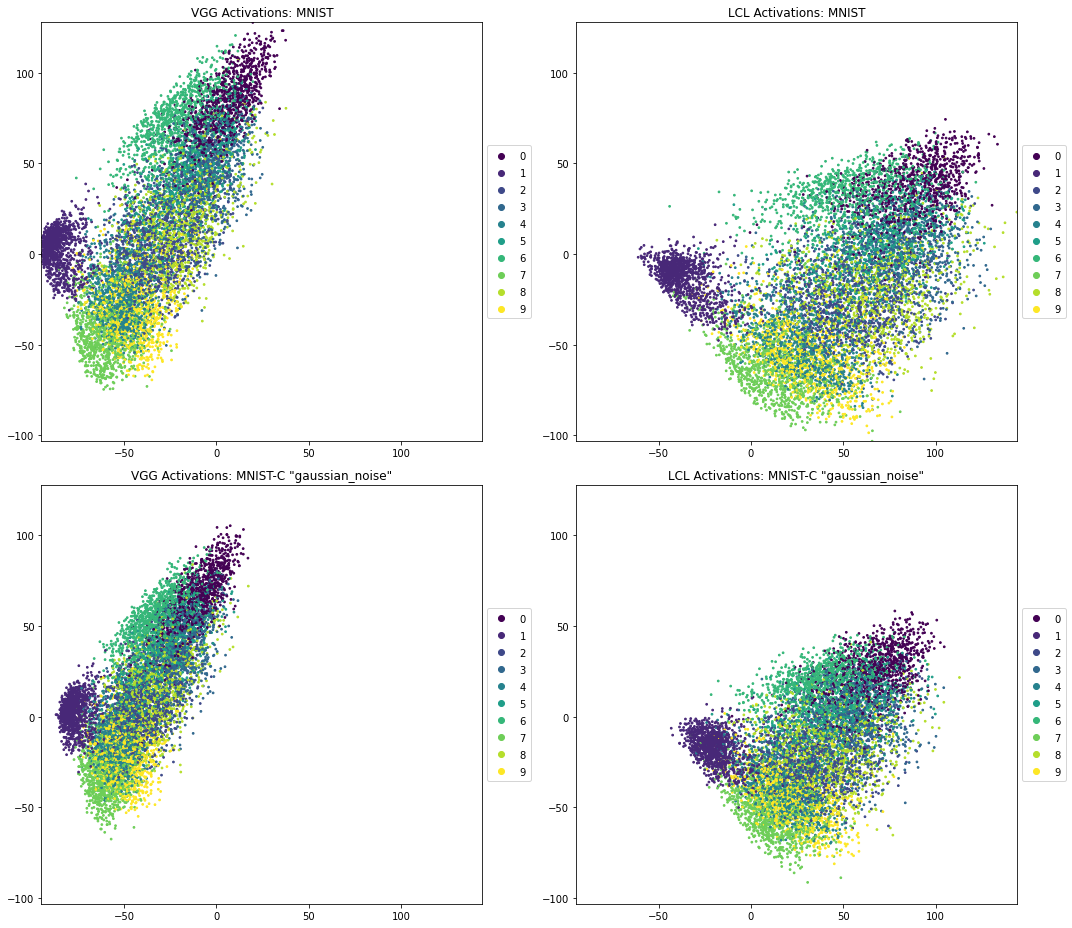

In [118]:
def generate_pca_plot_data(raw_data):
    pca_data = pca.transform(raw_data.reshape((raw_data.shape[0], raw_data.shape[1]*raw_data.shape[2]*raw_data.shape[3])))
    return pca_data[:,0], pca_data[:,1]

pca_full = pca.transform(full)

xmin = np.min(pca_full[:,0])
xmax = np.max(pca_full[:,0])
ymin = np.min(pca_full[:,1])
ymax = np.max(pca_full[:,1])
print(xmin, xmax, ymin, ymax)

fig, axs = plt.subplots(2, 2, figsize=(15,13))
plt.setp(axs, xlim=(xmin, xmax), ylim=(ymin, ymax))

scatter_plot = axs[0,0].scatter(*generate_pca_plot_data(data['identity']['vgg']), c=data['identity']['labels'], cmap='tab10', s=3)
axs[0,0].set_title('VGG Activations: MNIST')
axs[0,0].legend(*scatter_plot.legend_elements(), loc='center left', bbox_to_anchor=(1, 0.5))

scatter_plot = axs[0,1].scatter(*generate_pca_plot_data(data['identity']['lcl']), c=data['identity']['labels'], cmap='tab10', s=3)
axs[0,1].set_title('LCL Activations: MNIST')
axs[0,1].legend(*scatter_plot.legend_elements(), loc='center left', bbox_to_anchor=(1, 0.5))

scatter_plot = axs[1,0].scatter(*generate_pca_plot_data(data['gaussian_noise']['vgg']), c=data['gaussian_noise']['labels'], cmap='tab10', s=3)
axs[1,0].set_title('VGG Activations: MNIST-C "gaussian_noise"')
axs[1,0].legend(*scatter_plot.legend_elements(), loc='center left', bbox_to_anchor=(1, 0.5))

scatter_plot = axs[1,1].scatter(*generate_pca_plot_data(data['gaussian_noise']['lcl']), c=data['gaussian_noise']['labels'], cmap='tab10', s=3)
axs[1,1].set_title('LCL Activations: MNIST-C "gaussian_noise"')
axs[1,1].legend(*scatter_plot.legend_elements(), loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(15,13))
plt.setp(axs, xlim=(xmin, xmax), ylim=(ymin, ymax))

scatter_plot = axs[0,0].scatter(*generate_pca_plot_data(data['identity']['vgg']), c=data['identity']['labels'], cmap='viridis', s=3)
axs[0,0].set_title('VGG Activations: MNIST')
axs[0,0].legend(*scatter_plot.legend_elements(), loc='center left', bbox_to_anchor=(1, 0.5))

scatter_plot = axs[0,1].scatter(*generate_pca_plot_data(data['identity']['lcl']), c=data['identity']['labels'], cmap='viridis', s=3)
axs[0,1].set_title('LCL Activations: MNIST')
axs[0,1].legend(*scatter_plot.legend_elements(), loc='center left', bbox_to_anchor=(1, 0.5))

scatter_plot = axs[1,0].scatter(*generate_pca_plot_data(data['gaussian_noise']['vgg']), c=data['gaussian_noise']['labels'], cmap='viridis', s=3)
axs[1,0].set_title('VGG Activations: MNIST-C "gaussian_noise"')
axs[1,0].legend(*scatter_plot.legend_elements(), loc='center left', bbox_to_anchor=(1, 0.5))

scatter_plot = axs[1,1].scatter(*generate_pca_plot_data(data['gaussian_noise']['lcl']), c=data['gaussian_noise']['labels'], cmap='viridis', s=3)
axs[1,1].set_title('LCL Activations: MNIST-C "gaussian_noise"')
axs[1,1].legend(*scatter_plot.legend_elements(), loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

### t-SNE

In [65]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_full = tsne.fit_transform(full)

/home/claude/development/mt_object_recognition/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/claude/development/mt_object_recognition/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [66]:
tsne_full

array([[-50.737328  ,   9.779857  ],
       [-10.445861  ,  47.06669   ],
       [ -0.13510951,  37.742416  ],
       ...,
       [ 29.312704  , -27.171516  ],
       [ 22.949936  ,   1.8364357 ],
       [ 36.0674    ,  46.301163  ]], dtype=float32)

-68.80066 69.97885 -68.60077 64.716736


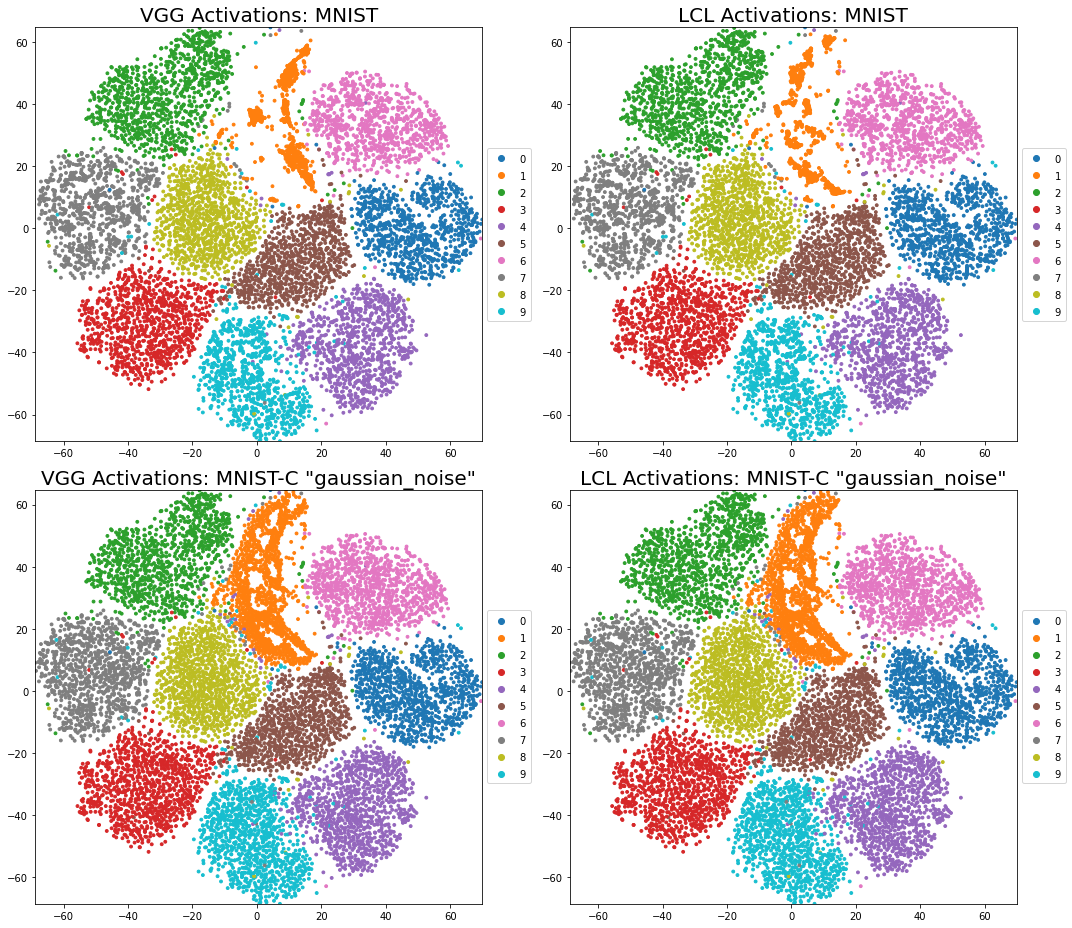

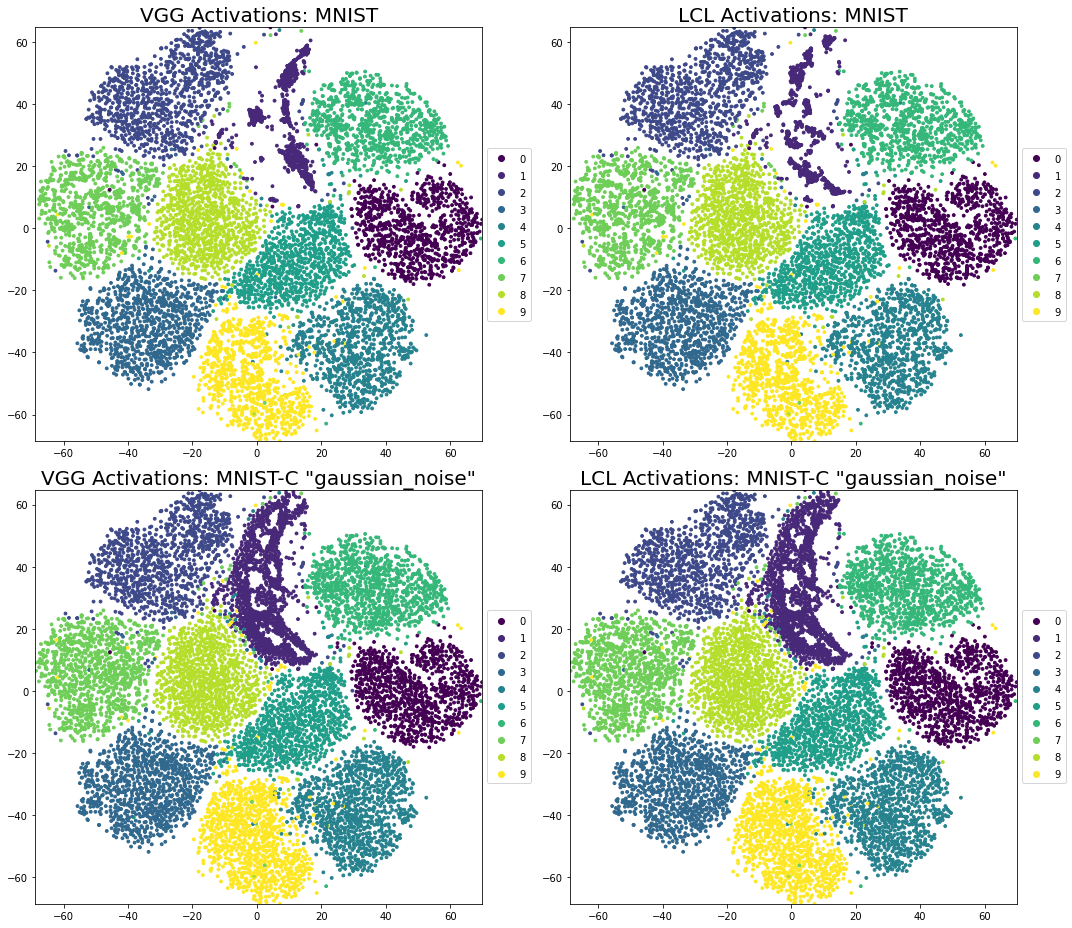

In [113]:
def tsne_scatter(axs, x, y, x_data, y_data, c, cmap='tab10', plot_title=''):
    scatter_plot = axs[x,y].scatter(x_data, y_data, c=c, cmap=cmap, s=8)
    axs[x,y].legend(*scatter_plot.legend_elements(), loc='center left', bbox_to_anchor=(1, 0.5))
    axs[x,y].set_title(plot_title, size=20)

xmin = np.min(tsne_full[:,0])
xmax = np.max(tsne_full[:,0])
ymin = np.min(tsne_full[:,1])
ymax = np.max(tsne_full[:,1])
print(xmin, xmax, ymin, ymax)

fig, axs = plt.subplots(2, 2, figsize=(15,13))
plt.setp(axs, xlim=(xmin, xmax), ylim=(ymin, ymax))

tsne_scatter(axs, 0, 0, tsne_full[:10000, 0], tsne_full[:10000,1], c=data['identity']['labels'], cmap='tab10', plot_title='VGG Activations: MNIST')
tsne_scatter(axs, 0, 1, tsne_full[10000:20000,0], tsne_full[10000:20000,1], c=data['identity']['labels'], cmap='tab10', plot_title='LCL Activations: MNIST')
tsne_scatter(axs, 1, 0, tsne_full[20000:30000,0], tsne_full[20000:30000,1], c=data['identity']['labels'], cmap='tab10', plot_title='VGG Activations: MNIST-C "gaussian_noise"')
tsne_scatter(axs, 1, 1, tsne_full[30000:,0], tsne_full[30000:,1], c=data['identity']['labels'], cmap='tab10', plot_title='LCL Activations: MNIST-C "gaussian_noise"')

plt.tight_layout()
plt.show()


fig, axs = plt.subplots(2, 2, figsize=(15,13))
plt.setp(axs, xlim=(xmin, xmax), ylim=(ymin, ymax))

tsne_scatter(axs, 0, 0, tsne_full[:10000, 0], tsne_full[:10000,1], c=data['identity']['labels'], cmap='viridis', plot_title='VGG Activations: MNIST')
tsne_scatter(axs, 0, 1, tsne_full[10000:20000,0], tsne_full[10000:20000,1], c=data['identity']['labels'], cmap='viridis', plot_title='LCL Activations: MNIST')
tsne_scatter(axs, 1, 0, tsne_full[20000:30000,0], tsne_full[20000:30000,1], c=data['identity']['labels'], cmap='viridis', plot_title='VGG Activations: MNIST-C "gaussian_noise"')
tsne_scatter(axs, 1, 1, tsne_full[30000:,0], tsne_full[30000:,1], c=data['identity']['labels'], cmap='viridis', plot_title='LCL Activations: MNIST-C "gaussian_noise"')

plt.tight_layout()

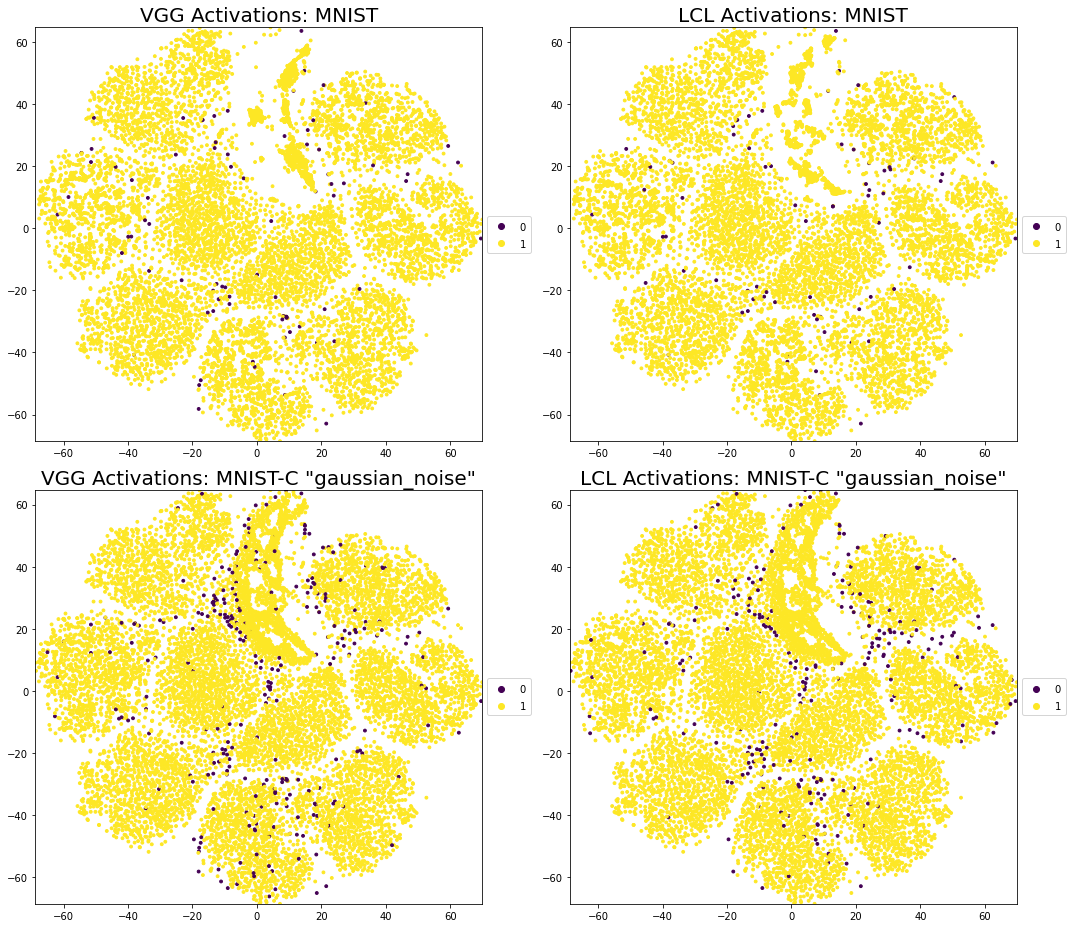

In [116]:
vgg_correct = (data['identity']['labels'] == data['identity']['vgg_pred'])
lcl_correct = (data['identity']['labels'] == data['identity']['lcl_pred'])
vgg_incorrect = (data['identity']['labels'] != data['identity']['vgg_pred'])
lcl_incorrect = (data['identity']['labels'] != data['identity']['lcl_pred'])
both_incorrect = vgg_incorrect | lcl_incorrect


fig, axs = plt.subplots(2, 2, figsize=(15,13))
plt.setp(axs, xlim=(xmin, xmax), ylim=(ymin, ymax))

tsne_scatter(axs, 0, 0, tsne_full[:10000, 0], tsne_full[:10000,1], c=(data['identity']['labels'] == data['identity']['vgg_pred']), cmap='viridis', plot_title='VGG Activations: MNIST')
tsne_scatter(axs, 0, 1, tsne_full[10000:20000,0], tsne_full[10000:20000,1], c=(data['identity']['labels'] == data['identity']['lcl_pred']), cmap='viridis', plot_title='LCL Activations: MNIST')
tsne_scatter(axs, 1, 0, tsne_full[20000:30000,0], tsne_full[20000:30000,1], c=(data['gaussian_noise']['labels'] == data['gaussian_noise']['vgg_pred']), cmap='viridis', plot_title='VGG Activations: MNIST-C "gaussian_noise"')
tsne_scatter(axs, 1, 1, tsne_full[30000:,0], tsne_full[30000:,1], c=(data['gaussian_noise']['labels'] == data['gaussian_noise']['lcl_pred']), cmap='viridis', plot_title='LCL Activations: MNIST-C "gaussian_noise"')

plt.tight_layout()
plt.show()


